Importowanie potrzebnych bibliotek

In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import pandas as pd
import cv2
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Określenie ścieżki do naszego data setu

In [3]:
data_directory = "D:\Projects\Python\Sign classificator\data"
train_directory = "D:\Projects\Python\Sign classificator\data\Train"
test_directory = "D:\Projects\Python\Sign classificator\data\Test"

#Model potrzebuje stałego rozmiaru zdjęć
image_height = 30
image_width = 30
channels = 3

Teraz sprawdzimy ile klas znaków ma dataset

In [4]:
amount_of_categories = len(os.listdir(train_directory))
amount_of_categories

43

In [5]:
#Poszczególne klasy w datasecie
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

Zobrazowanie ilości zdjęć w poszczególnych klasach

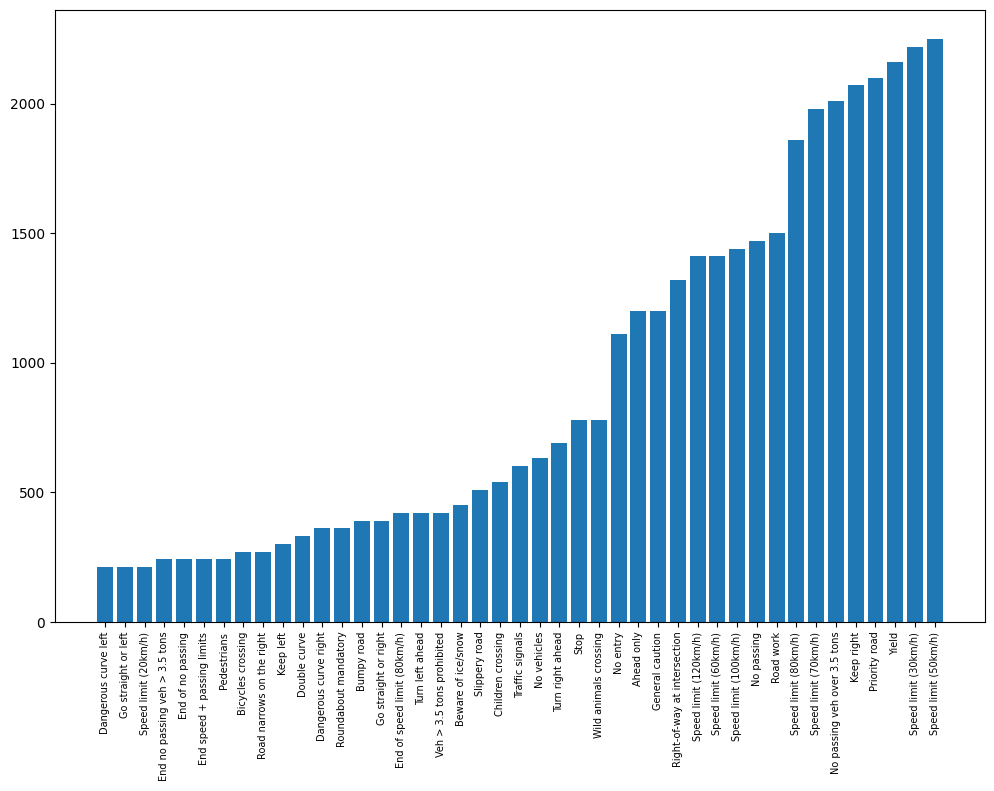

In [6]:
folders = os.listdir(train_directory)
train_num = []
class_num = []

for folder in folders:
    train_files = os.listdir(os.path.join(train_directory, folder))
    train_num.append(len(train_files))
    class_num.append(classes[int(folder)])
    
#Sort po największej ilości zdjęć
zipped_lists_number = zip(train_num, class_num)
sorted_zipped_lists_number = sorted(zipped_lists_number)
train_num = []
class_num = []

for sorted_zipped_list_number in sorted_zipped_lists_number:
    train_num.append(sorted_zipped_list_number[0])
    class_num.append(sorted_zipped_list_number[1])

#Wyplotowanie
plt.figure(figsize=(12,9))
plt.bar(class_num, train_num)
plt.xticks(class_num, rotation='vertical', fontsize=7)
plt.subplots_adjust(bottom=0.2)
plt.show()

Załadowanie danych do trenowania

In [44]:
img_data = []
img_labels = []
img_train = []

for i in range(amount_of_categories):
    class_path = os.path.join(train_directory, str(i))
    imgs = os.listdir(class_path)
    for img in imgs:
        try:
            image = cv2.imread(os.path.join(class_path, img), cv2.IMREAD_COLOR)
            image_fromarray = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            resized_image = image_fromarray.resize((image_width, image_height))
            img_data.append(np.array(resized_image))
            img_labels.append(i)
            img_train.append(image_fromarray)
        except:
            print("Error in img " + img)
    
img_data = np.array(img_data)
img_labels = np.array(img_labels)

print(img_data.shape, img_labels.shape)


(39209, 30, 30, 3) (39209,)


Pokazanie przykładowych zdjęć treningowych

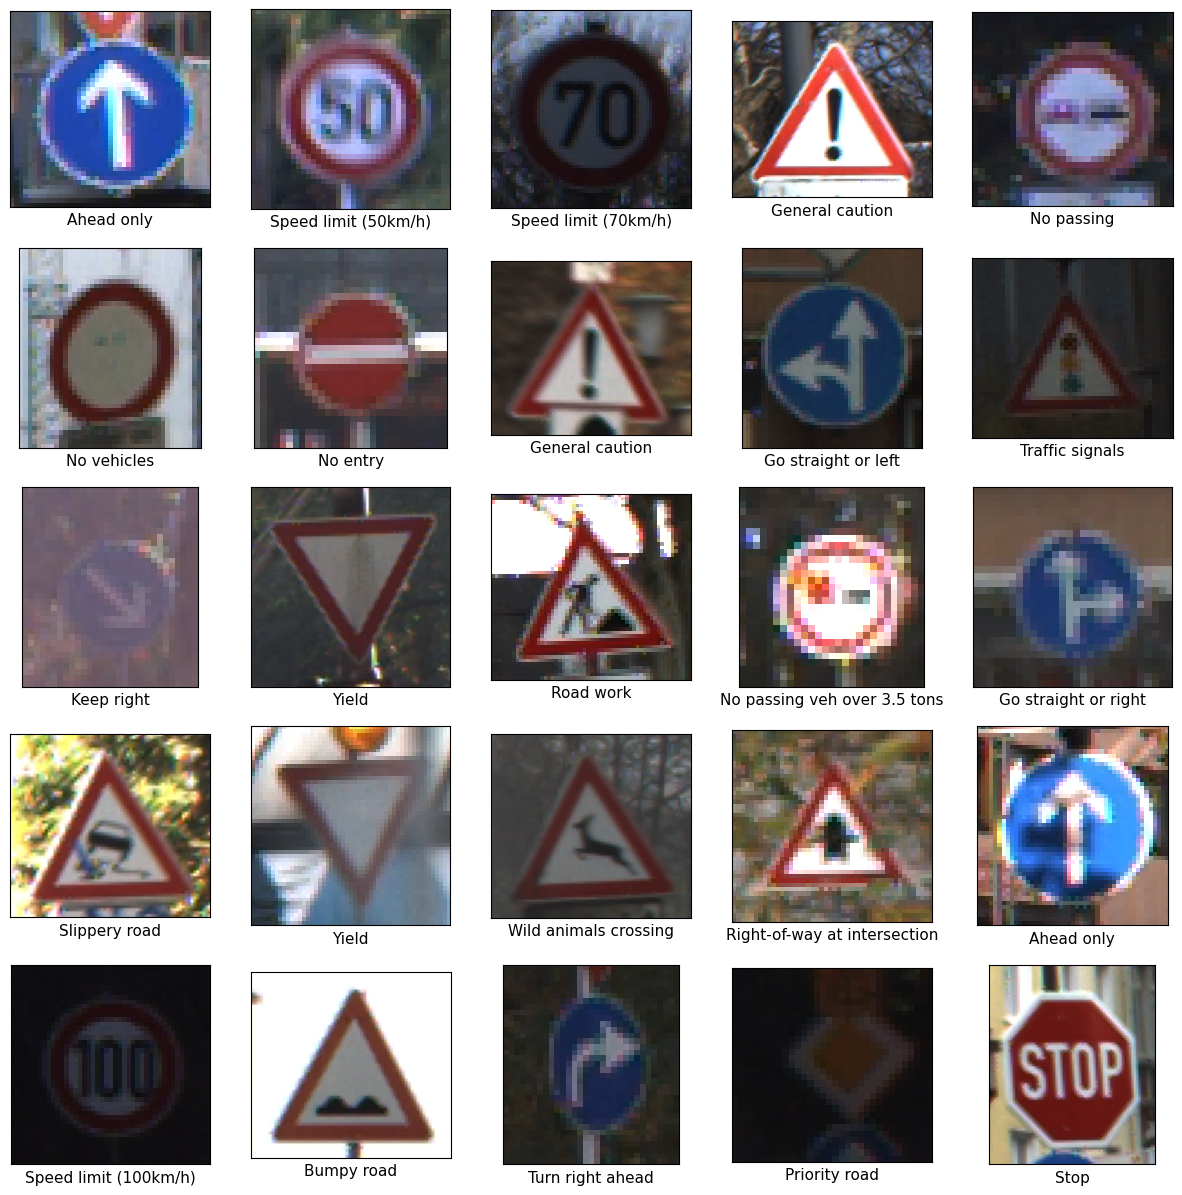

In [50]:
plt.figure(figsize = (15, 15))

start_index = random.randint(0, len(img_train)-25)
for i in range(25):
    random_img = random.randint(0, len(img_train))
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    col = 'black'
    plt.xlabel(classes[img_labels[random_img]], color = col, fontsize=11)
    plt.imshow(img_train[random_img])
plt.show()

Mieszanie danych treningowych

In [8]:
shuffle_indexes = np.arange(img_data.shape[0])
np.random.shuffle(shuffle_indexes)
img_data = img_data[shuffle_indexes]
img_labels = img_labels[shuffle_indexes]

Dzielenie danych na treningowe i validacyjne 

In [9]:
X_train, X_val, y_train, y_val = train_test_split(img_data, img_labels, test_size=0.3, random_state=42, shuffle= True)
X_train = X_train/255 #Normalizacja wartości pikseli float miedzy 0 a 1 który nadaje się do trenowania
X_val = X_val/255

y_train = keras.utils.to_categorical(y_train, amount_of_categories)
y_val = keras.utils.to_categorical(y_val, amount_of_categories)   

print("X traing ", X_train.shape)
print("X validation ", X_val.shape)
print("y traing ", y_train.shape)
print("y validation ", y_val.shape)

X traing  (27446, 30, 30, 3)
X validation  (11763, 30, 30, 3)
y traing  (27446, 43)
y validation  (11763, 43)


Tworzenie modelu

In [10]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", input_shape=(image_height, image_width, channels)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

#Model jest Sequential, czyli jest stackiem warstw jedna po drugiej i zawiera:
#1. Dwie warstwy splotowe 2D z odpowiednio 16 filtrami i 32 filtrami każda wykorzystuje rozmiar jądra (3,3) i aktywację ReLU
#   jest to funkcja liniowa która z wartości ujemnych robi 0 a dla większych od 0 nic nie zmienia (ReLU(x) = max(0, x))
#2. MaxPool2D (2,2) redukuje rozdzielczość biorąc maksymalną wartość jendego z 4 pikseli
#3. BatchNormalization często sie stosuje do poprawienia stabilności trenowania
#4. Koljne warstwy spolotwe
#5. Flatten() z kilku wymiarów zrobi  1 wymiarową array jest to potrzebne żeby przesłać data do fully contected (dense) layers 
#6. W dense każdy neuron jest połączony z każdym z poprzedniej warstwy 
#7. Dopout(0.5) oznacza że 50% inputu bedzie ustawiona jako 0, robi się tak żeby sieć nie była tak wrażliwa na pojędyncze inputy
#   Zapobiega to overfitting czyli uczeniu sie pikseli na pamięć przez sieć
#8. Ostatnia warstwa da nam przewidywalne prawdopodobieństwo na daną klase. Jest 43 klas znaków więc chcemy 43 outputów
#   Softmax jest używana do kowersji wektora do dystrybucji prawdopodobieństwa. Możemy wtedy ładnie zobaczyć na ile % model jest pewny że to ta klasa


learning_rate = 0.001
epochs = 20

opt = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5)) #Optimazer pomoga modelowi się uczyć na dużych datasetach 
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]) #Configuracja procesu uczenia, jaką funkcje loss ma użyć,optimizer, jednostka sprawdzania

Augmentacja danych 

In [11]:
aug = ImageDataGenerator(
        rotation_range= 10, #Max obrót
        zoom_range=0.15, #Przybliżenie lub oddalnie 15%
        width_shift_range=0.1, #Przesunięcie po szerokości max po 10%
        height_shift_range=0.1, #Po wysokości
        shear_range=0.15, #Max przechylenie obrazka wzdłóż z któreś osi radiany
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode="nearest" #Wypełnienie nowo powstałych pikseli najblizszym 
    )

Trenowanie modelu

In [12]:
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/20
858/858 [==============================] - 30s 31ms/step - loss: 0.9817 - accuracy: 0.7423 - val_loss: 0.1658 - val_accuracy: 0.9460
Epoch 2/20
858/858 [==============================] - 27s 31ms/step - loss: 0.1295 - accuracy: 0.9639 - val_loss: 0.0311 - val_accuracy: 0.9897
Epoch 3/20
858/858 [==============================] - 26s 31ms/step - loss: 0.0687 - accuracy: 0.9799 - val_loss: 0.0514 - val_accuracy: 0.9830
Epoch 4/20
858/858 [==============================] - 26s 31ms/step - loss: 0.0690 - accuracy: 0.9804 - val_loss: 0.0087 - val_accuracy: 0.9980
Epoch 5/20
858/858 [==============================] - 26s 31ms/step - loss: 0.0461 - accuracy: 0.9858 - val_loss: 0.0068 - val_accuracy: 0.9974
Epoch 6/20
858/858 [==============================] - 26s 31ms/step - loss: 0.0330 - accuracy: 0.9899 - val_loss: 0.0197 - val_accuracy: 0.9948
Epoch 7/20
858/858 [==============================] - 27s 31ms/step - loss: 0.0322 - accuracy: 0.9911 - val_loss: 0.0039 - val_accuracy:

Ocena modelu

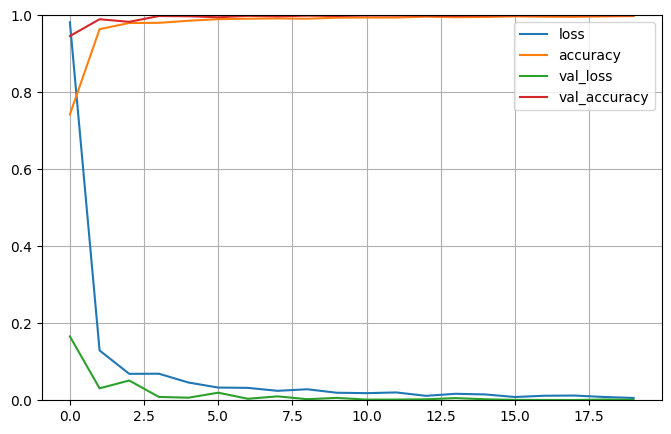

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Sprawdzenie modelu na danych testowych

395/395 [==============================] - 3s 8ms/step
Test Data accuracy:  98.63024544734759


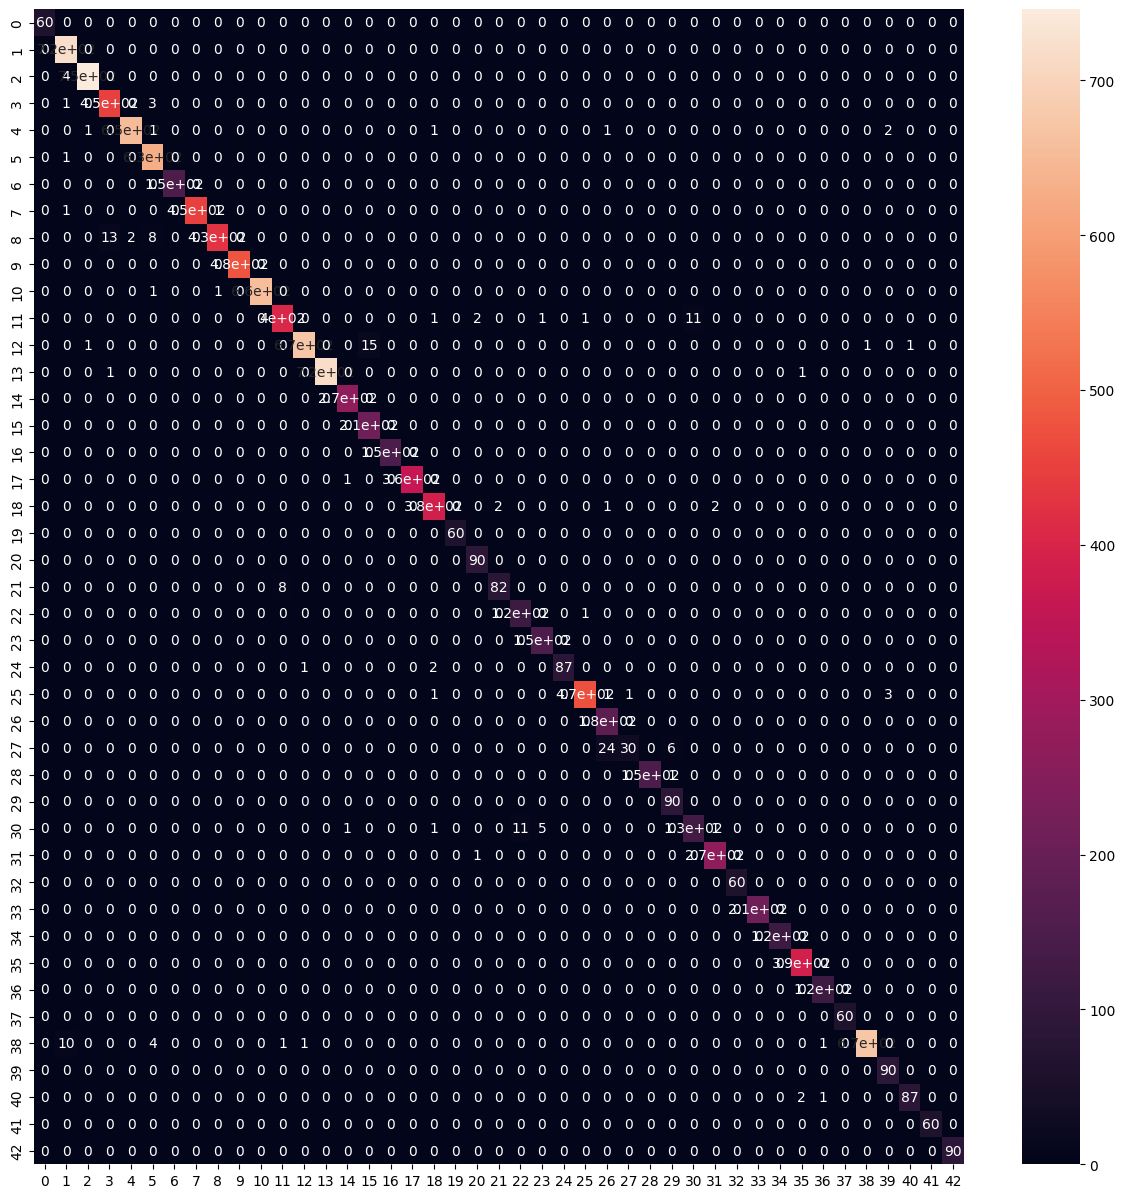

In [22]:
test = pd.read_csv(os.path.join(data_directory, "Test.csv"))

labels = test["ClassId"].values
imgs = os.listdir(test_directory)

data = []
for img in imgs:
    try:
        image = cv2.imread(os.path.join(test_directory, img), cv2.IMREAD_COLOR)
        image_fromarray = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        resized_image = image_fromarray.resize((image_width, image_height))
        data.append(np.array(resized_image))
    except:
        print("Error in img " + img)

X_test = np.array(data)/255
pred = model.predict(X_test)
pred_labels = np.argmax(pred, axis=1)

print('Test Data accuracy: ',accuracy_score(labels, pred_labels)*100)

cf = confusion_matrix(labels, pred_labels)
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (15,15))
sns.heatmap(df_cm, annot=True)
plt.show()

In [15]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.98      1.00      0.99       720
           2       1.00      0.99      1.00       750
           3       0.97      0.99      0.98       450
           4       1.00      0.99      0.99       660
           5       0.97      1.00      0.99       630
           6       1.00      1.00      1.00       150
           7       1.00      1.00      1.00       450
           8       1.00      0.95      0.97       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.98      0.96      0.97       420
          12       1.00      0.97      0.99       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      1.00       270
          15       0.93      1.00      0.97       210
          16       1.00      1.00      1.00       150
          17       1.00    

Wizualicja dancyh testowych i predykcja

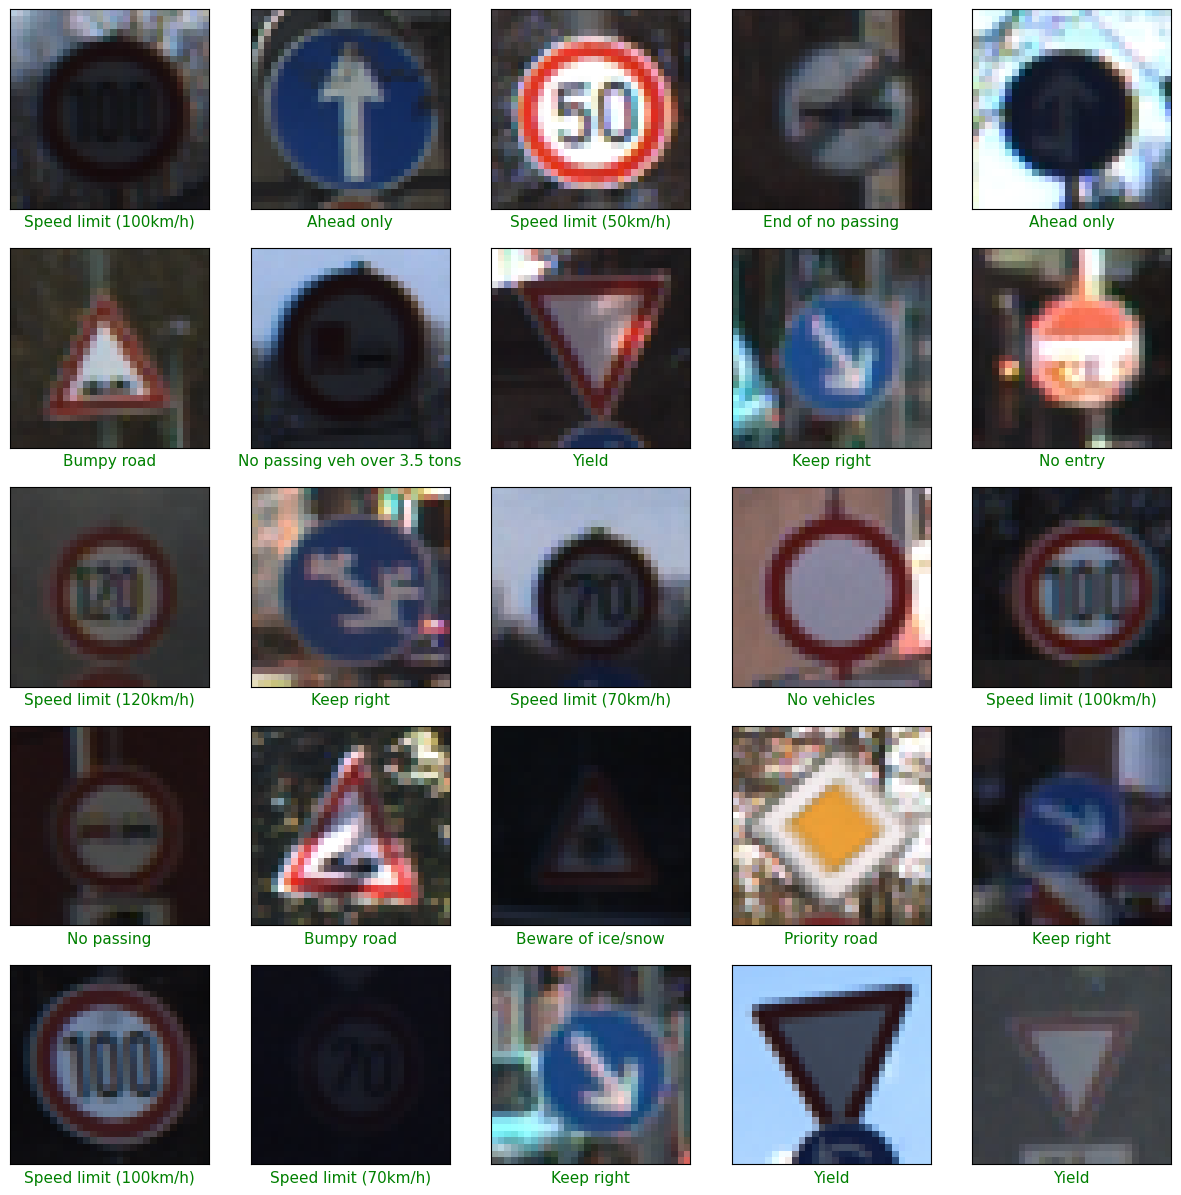

In [39]:
plt.figure(figsize = (15, 15))

start_index = random.randint(0, X_test.shape[0]-25)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_labels[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel(classes[prediction], color = col, fontsize=11)
    plt.imshow(X_test[start_index + i])
plt.show()

Zapisanie wytrenowanego modelu to pliku

In [17]:
model.save("Sign_classification_model.h5")

Error in img a3d6c688748dd0eb68d9e901158bb453.jpg
3/3 [==============================] - 0s 8ms/step


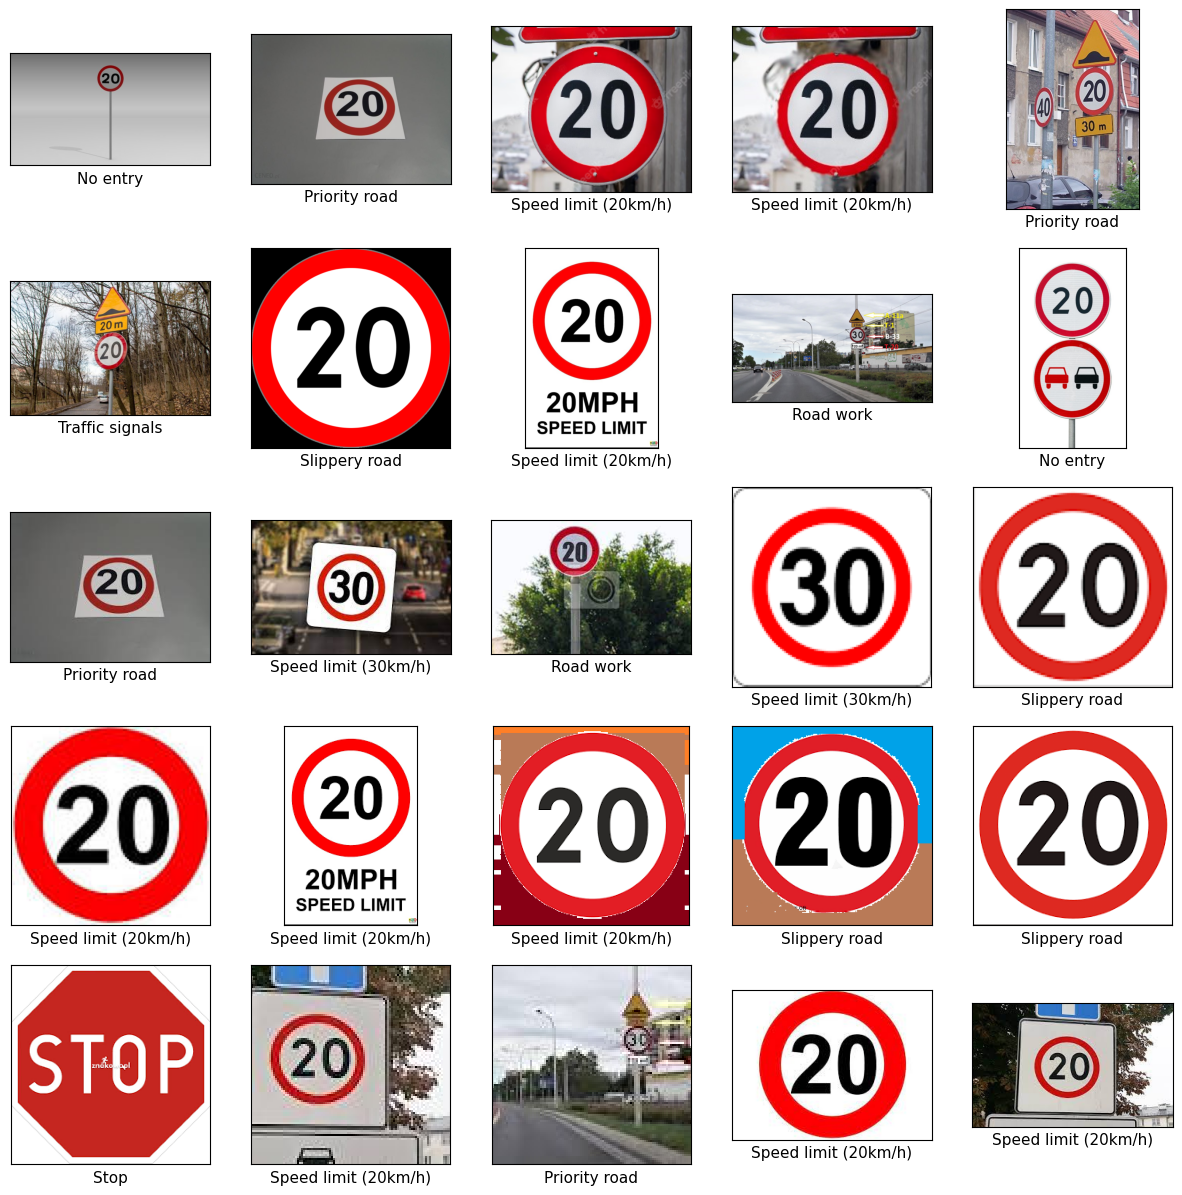

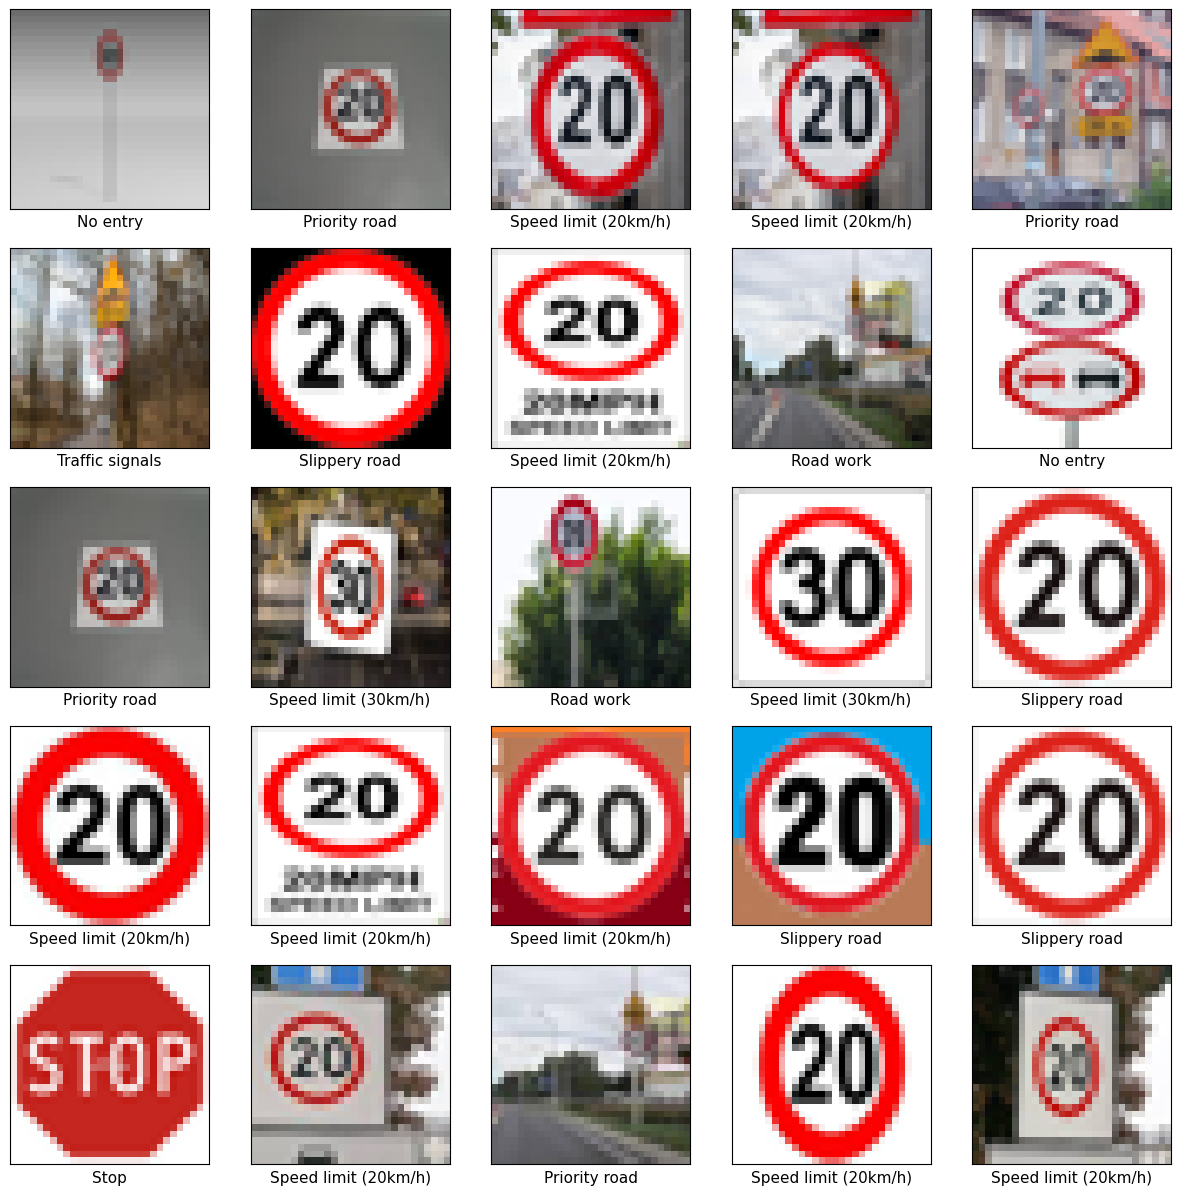

In [83]:
imgs = os.listdir("data\RandomTest")

imgs_org = []
data = []
for img in imgs:
    try:
        image = cv2.imread(os.path.join("data\RandomTest", img), cv2.IMREAD_COLOR)
        image_fromarray = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        resized_image = image_fromarray.resize((image_width, image_height))
        data.append(np.array(resized_image))
        imgs_org.append(image_fromarray)
    except:
        print("Error in img " + img)

X_test = np.array(data)/255
pred = model.predict(X_test)
pred_labels = np.argmax(pred, axis=1)

plt.figure(figsize = (15, 15))

start_index = random.randint(0, X_test.shape[0]-25)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_labels[start_index + i]
    col = 'black'
    plt.xlabel(classes[prediction], color = col, fontsize=11)
    plt.imshow(imgs_org[start_index + i])
plt.show()

plt.figure(figsize = (15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_labels[start_index + i]
    col = 'black'
    plt.xlabel(classes[prediction], color = col, fontsize=11)
    plt.imshow(X_test[start_index + i])
plt.show()